In [3]:
import pandas as pd
import pickle
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from qcnn.Vqnn import QuantumLayer, QuantumCircuit, QuantumRegister, QiskitCircuitModule, QiskitCircuitModuleException, QiskitCircuitModuleExceptionData
from qcnn.Vqnn import VQNNModel
import tensorflow as tf
import keras

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from sklearn.preprocessing import StandardScaler

In [4]:
num_features = 4
df = pd.read_csv('./data/Apple stock.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [6]:
df['RETURNS'] = df['Close'].pct_change()
df['PRX_MA_ND'] = df['Close'].rolling(window=5).mean()
df['VOLATILITY'] = df['Close'].rolling(window=5).std()
df['TP1_RETURNS'] = df['RETURNS'].shift(-1)

df.dropna(inplace=True)
df = df.set_index('Date')

In [7]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,RETURNS,PRX_MA_ND,VOLATILITY,TP1_RETURNS
Date,,,,,,,,,,
2022-03-17,158.610001,161.000000,157.630005,160.619995,160.619995,75615400,0.006454,156.129996,4.047635,0.020919
2022-03-18,160.509995,164.479996,159.759995,163.979996,163.979996,123351200,0.020919,157.979996,5.198159,0.008538
2022-03-21,163.509995,166.350006,163.009995,165.380005,165.380005,95811400,0.008538,160.931998,4.034302,0.020801
2022-03-22,165.509995,169.419998,164.910004,168.820007,168.820007,81532000,0.020801,163.678000,3.724629,0.008234
2022-03-23,167.990005,172.639999,167.649994,170.210007,170.210007,98062700,0.008234,165.802002,3.836986,0.022678


In [8]:
from sklearn.preprocessing import MinMaxScaler

df_x = df[['RETURNS', 'Volume', 'PRX_MA_ND', 'VOLATILITY']]
df_y = df['TP1_RETURNS']

df_x_scaler = MinMaxScaler().fit(df_x)

forward_test_date = '2021-01-01'

fdf_x = df_x.loc[forward_test_date:]
fdf_y = df_y.loc[forward_test_date:]
df_x = df_x.loc[:forward_test_date]
df_y = df_y.loc[:forward_test_date]

df_x_scaled = pd.DataFrame(df_x_scaler.transform(df_x))
fdf_x_scaled = pd.DataFrame(df_x_scaler.transform(fdf_x))

x_train, x_test, y_train, y_test = train_test_split(df_x_scaled,
                                                    df_y,
                                                    test_size=0.25,
                                                    random_state=42)
# notes: manual neural network

In [9]:
x_train = np.expand_dims(x_train.values, 1).astype(np.float32)
y_train = np.expand_dims(y_train.values, 1).astype(np.float32)
x_validation = np.expand_dims(x_test.values, 1).astype(np.float32)
y_validation = np.expand_dims(y_test.values, 1).astype(np.float32)

In [10]:
qnn_model = VQNNModel()
qnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                                     beta_1=0.9,
                                                     beta_2=0.999,
                                                     epsilon=1e-07),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=["mean_squared_error"])
qnn_model.run_eagerly = True

In [11]:
import os

log_dir = "./logs/fit/"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [2]:
qnn_model.fit(
x_train, y_train, epochs=1, batch_size=1,
              callbacks=[tensorboard_callback])

NameError: name 'qnn_model' is not defined

In [55]:
len(df_x_scaled)

10096

In [51]:
num_of_features = fdf_x_scaled.shape[1]
qnn_predictions = []
for entry in fdf_x_scaled.iterrows():
    fdf_x_predict_tensor = tf.reshape(tf.convert_to_tensor(entry[1]), [1, num_of_features])
    qnn_forecast = qnn_model.predict(fdf_x_predict_tensor)
    qnn_predictions.append(qnn_forecast[-1, -1, -1])
signal = [0 if x <= 0 else 1 for x in qnn_predictions]

Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [==============================] - 5s 5s/step
Job Status: job has successfully run
1/1 [=

In [53]:
len(signal)

308

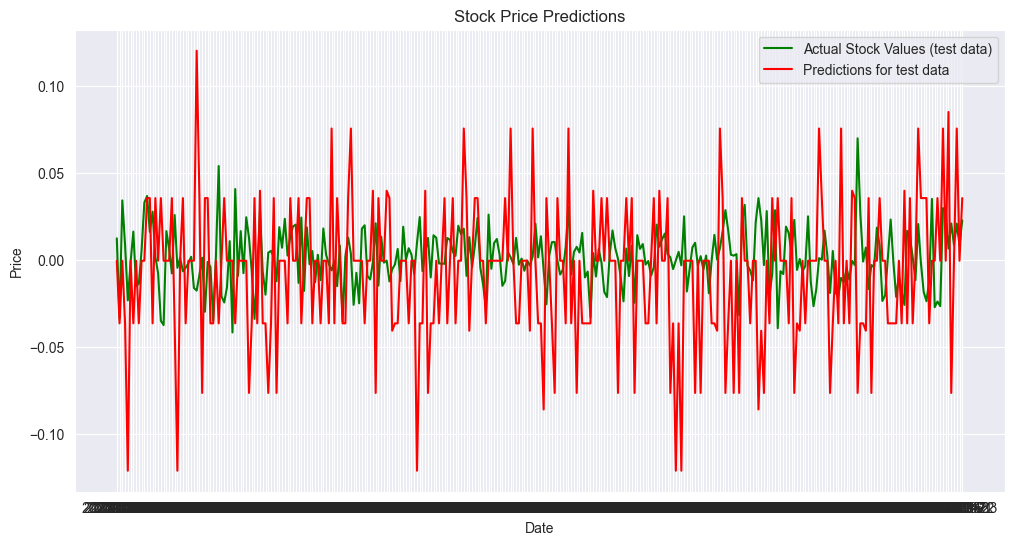

In [62]:
# plot predictions vs actual. also plot the stocks from the training set
plt.figure(figsize=(12, 6))
# plt.plot(df_y[:300].index, df_y[:300], label='Stock/ Training Data', color='blue')
plt.plot(fdf_y.index, fdf_y, label='Actual Stock Values (test data)', color='green')
plt.plot(fdf_y.index, qnn_predictions, label='Predictions for test data', color='red')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

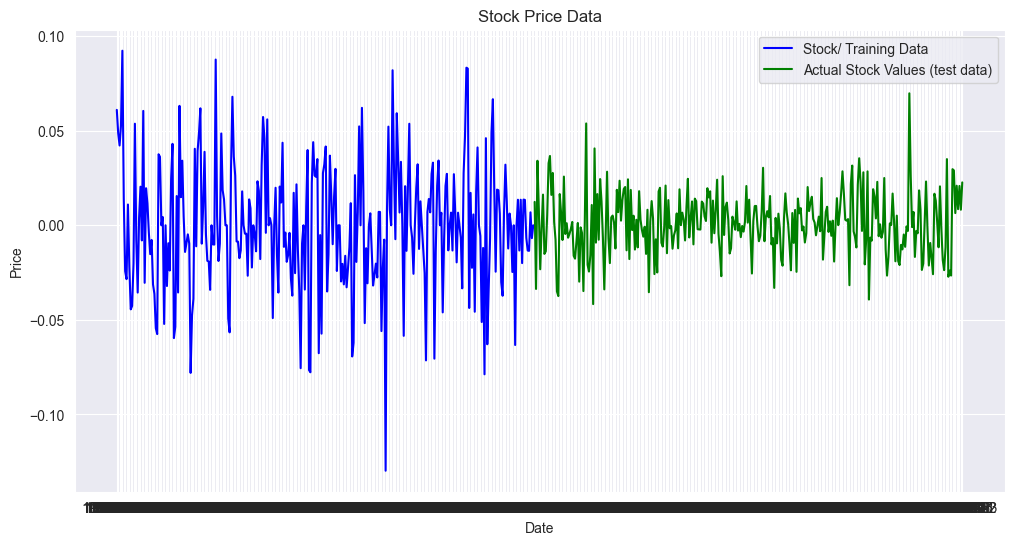

In [64]:
# plot predictions vs actual. also plot the stocks from the training set
plt.figure(figsize=(12, 6))
plt.plot(df_y[:300].index, df_y[:300], label='Stock/ Training Data', color='blue')
plt.plot(fdf_y.index, fdf_y, label='Actual Stock Values (test data)', color='green')
plt.title('Stock Price Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

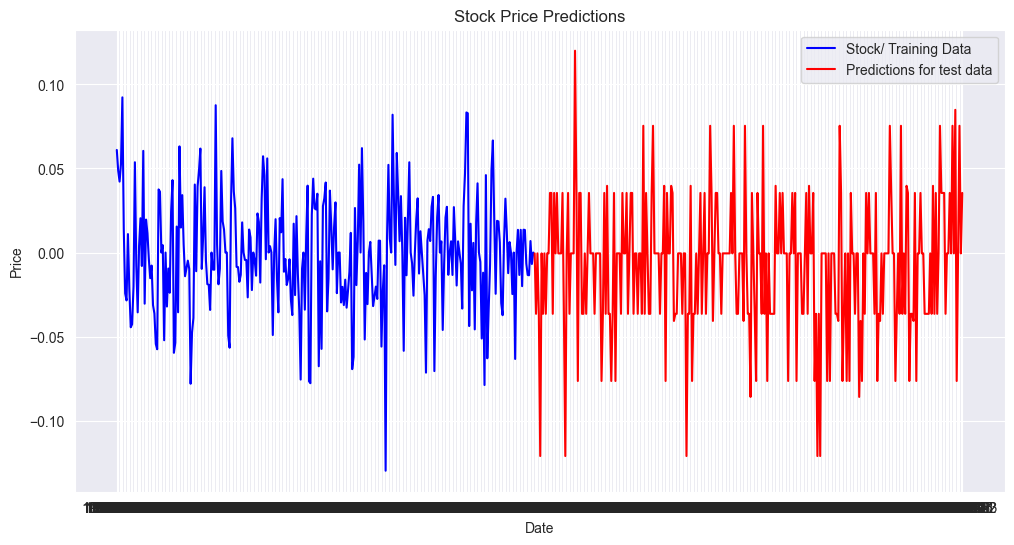

In [63]:
# plot predictions vs actual. also plot the stocks from the training set
plt.figure(figsize=(12, 6))
plt.plot(df_y[:300].index, df_y[:300], label='Stock/ Training Data', color='blue')
# plt.plot(fdf_y.index, fdf_y, label='Actual Stock Values (test data)', color='green')
plt.plot(fdf_y.index, qnn_predictions, label='Predictions for test data', color='red')
plt.title('Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [73]:
# calculate model accuracy, f1, and other metrics
mse = mean_squared_error(fdf_y, qnn_predictions)
r2 = r2_score(fdf_y, qnn_predictions, force_finite=True)
explained_var = explained_variance_score(fdf_y, qnn_predictions, force_finite=True)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')
print(f'explained variance: {explained_var}')

Mean Squared Error: 0.0019475554808728954
R2 Score: -6.1560980656654465
explained variance: -5.878784614382241


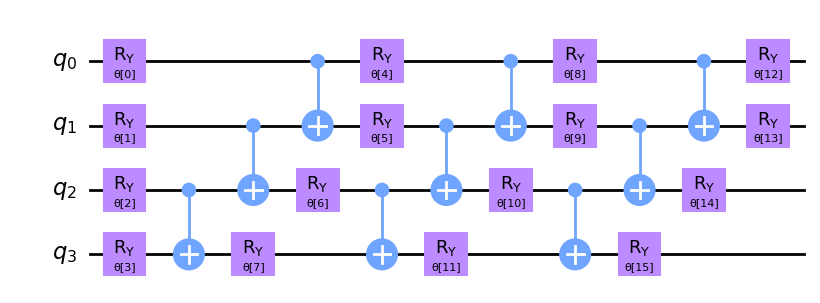

In [7]:
from qiskit_algorithms.optimizers import ADAM, L_BFGS_B, COBYLA
from qiskit.circuit.library import PauliFeatureMap, RealAmplitudes, ZZFeatureMap

num_features = x_train.shape[1]
# feature_map = PauliFeatureMap(feature_dimension=num_features, reps=2)
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
# optimizer = L_BFGS_B(maxiter=5) # takes too long 
# optimizer = COBYLA(maxiter=30) # innacurate   
optimizer = COBYLA(maxiter=60)
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

In [8]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    print(f"Iteration: {len(objective_func_vals)}")
    print(f"Objective function value: {obj_func_eval}")
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [9]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph
)

Iteration: 59
Objective function value: 0.008950824118310106


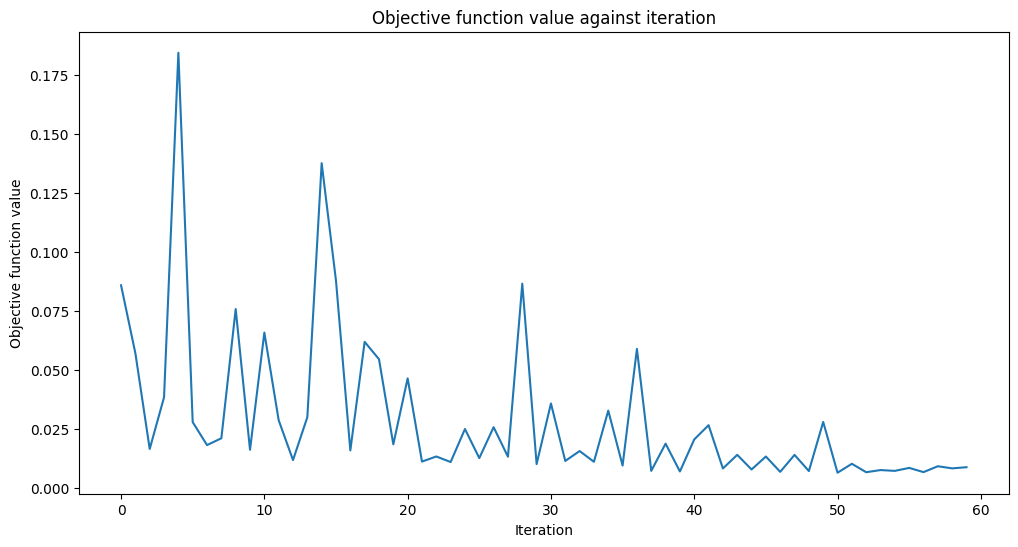

-7.031153854102092

In [10]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(x_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(x_train, y_train)

In [15]:
vqr.score(x_test, y_test)

-6.844213100423558

In [14]:
from sklearn.metrics import mean_squared_error

vqr_mse = mean_squared_error(y_test, vqr.predict(x_test))

# Calculate root mean squared error
vqr_rmse = np.sqrt(vqr_mse)

print("Root Mean Squared Error VQR: ", vqr_rmse)
print("Mean Squared Error VQR: ", vqr_mse)

Root Mean Squared Error VQR:  0.07960117454524443
Mean Squared Error VQR:  0.006336346988982469


In [ ]:
from sklearn.metrics import f1_score
vqr_f1 = f1_score(y_test, vqr.predict(x_test), average=None)
print("F1 Score VQR: ", vqr_f1)